<a href="https://colab.research.google.com/github/ferjjp/tp-ia-reconocimiento-de-imagenes-sin-cnn/blob/main/tenes_buena_postura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Test GPU

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 454.3MB 37kB/s 
Found GPU at: 


In [ ]:
#@title Librerías a usar
!pip install keras-utils
!pip install -U -q PyDrive

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd   
import numpy as np

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

  Created wheel for keras-utils: filename=keras_utils-1.0.13-cp37-none-any.whl size=2657 sha256=bac16a9d30d9ced0d2ea66cf4db383ad13251f5fd5cca66d6813fd24f6ad1e14
  Stored in directory: /root/.cache/pip/wheels/46/25/27/7707005c1cb27e1ffc8277b004ac295e34767b02b44d73d6be
Successfully built keras-utils
Librerías cargadas


# Creando el dataset

En este caso estamos agregando las imágenes a mano, lo cual no es ideal.
TODO: mejorar la carga de archivos

In [ ]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='fotos.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fotos.zip')

f.keys()

!rm -rf /content/fotos
!unzip fotos.zip -d /content/fotos


Librerías cargadas
Archive:  fotos.zip
   creating: /content/fotos/Buena/
  inflating: /content/fotos/Buena/20210603_172330.jpg  
  inflating: /content/fotos/Buena/20210603_172353.jpg  
  inflating: /content/fotos/Buena/20210603_172358.jpg  
  inflating: /content/fotos/Buena/20210603_172440.jpg  
  inflating: /content/fotos/Buena/20210603_172558.jpg  
  inflating: /content/fotos/Buena/20210603_172634.jpg  
  inflating: /content/fotos/Buena/20210603_172646.jpg  
  inflating: /content/fotos/Buena/20210603_173129.jpg  
  inflating: /content/fotos/Buena/20210603_173415.jpg  
  inflating: /content/fotos/Buena/20210603_173525.jpg  
  inflating: /content/fotos/Buena/20210603_173733.jpg  
  inflating: /content/fotos/Buena/20210603_173739.jpg  
  inflating: /content/fotos/Buena/20210603_173905.jpg  
  inflating: /content/fotos/Buena/20210603_174226.jpg  
  inflating: /content/fotos/Buena/20210603_174340.jpg  
  inflating: /content/fotos/Buena/20210603_174404.jpg  
  inflating: /content/fotos/Bu

Found 81 files belonging to 2 classes.
Using 65 files for training.
Found 81 files belonging to 2 classes.
Using 16 files for validation.


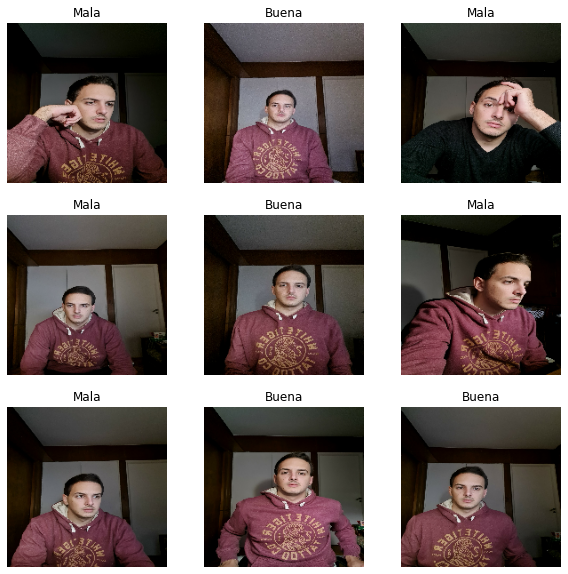

In [ ]:
batch_size = 32
img_height = 180 # original 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/fotos",
   validation_split=0.2,
   subset="training",
   seed=123,
   image_size=(img_width, img_height),
   batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/fotos",
   validation_split=0.2,
   subset="validation",
   seed=123,
   image_size=(img_width, img_width),
   batch_size=batch_size
)


class_names = train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



# Configuramos los dataset para mejorar performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(ds):
  return ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)

In [ ]:
# Estandarizamos los colores 
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_width,img_height,3))

## Aplicamos data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Entrenamiento

En ninguno de los dos casos se noto una mejora con data_agumentation y dropout para reducir el minimo overfitting o underfitting que hay

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               12441728  
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total params: 12,443,018
Trainable params: 12,443,018
Non-trainable params: 0
_________________________________________________________________


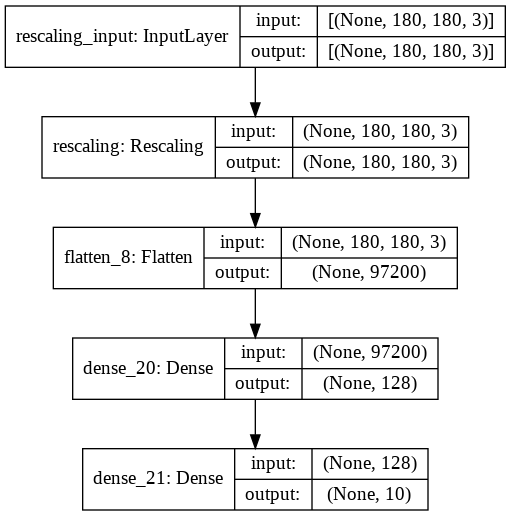

In [ ]:
num_classes = 2
learning_rate = 0.0001

model = tf.keras.Sequential([
    #data_augmentation, # en general no fue un buen candidato para data augmentation
    normalization_layer,
    tf.keras.layers.Flatten(input_shape=(img_width,img_height,3)),
    tf.keras.layers.Dense(128 ,input_shape=(img_width,img_height,3), activation='relu'),
    #tf.keras.layers.Dropout(0.5),# -- ni para dropout...
    tf.keras.layers.Dense(10),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=scc,
              metrics=['accuracy'])
model.build(input_shape=(batch_size,img_width,img_height,3))
model.summary()

tf.keras.utils.plot_model(
    model, to_file='RNA.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
iteraciones=200
history = model.fit(
  train_ds,
  verbose=1,
  validation_data=val_ds,
  epochs=iteraciones
)


Epoch 1/200
3/3 [==============================] - 0s 53ms/step - loss: 2.8687 - accuracy: 0.4462 - val_loss: 2.9564 - val_accuracy: 0.6875
Epoch 2/200
3/3 [==============================] - 0s 14ms/step - loss: 2.5112 - accuracy: 0.5692 - val_loss: 4.3448 - val_accuracy: 0.3125
Epoch 3/200
3/3 [==============================] - 0s 14ms/step - loss: 3.1537 - accuracy: 0.4923 - val_loss: 4.1328 - val_accuracy: 0.3125
Epoch 4/200
3/3 [==============================] - 0s 14ms/step - loss: 1.8520 - accuracy: 0.5538 - val_loss: 1.7060 - val_accuracy: 0.6875
Epoch 5/200
3/3 [==============================] - 0s 16ms/step - loss: 1.6083 - accuracy: 0.5385 - val_loss: 1.5399 - val_accuracy: 0.3125
Epoch 6/200
3/3 [==============================] - 0s 14ms/step - loss: 0.9854 - accuracy: 0.6615 - val_loss: 2.1831 - val_accuracy: 0.3125
Epoch 7/200
3/3 [==============================] - 0s 15ms/step - loss: 0.7617 - accuracy: 0.6923 - val_loss: 1.2711 - val_accuracy: 0.6875
Epoch 8/200
3/3 [===


# Evaluacion de la red

Falta:

1. Dividir el dataset original en 3, en vez de 2 (de esa forma tener uno de test)
2. Usar el dataset de test para comparar y armar matriz de confusiones y etc.

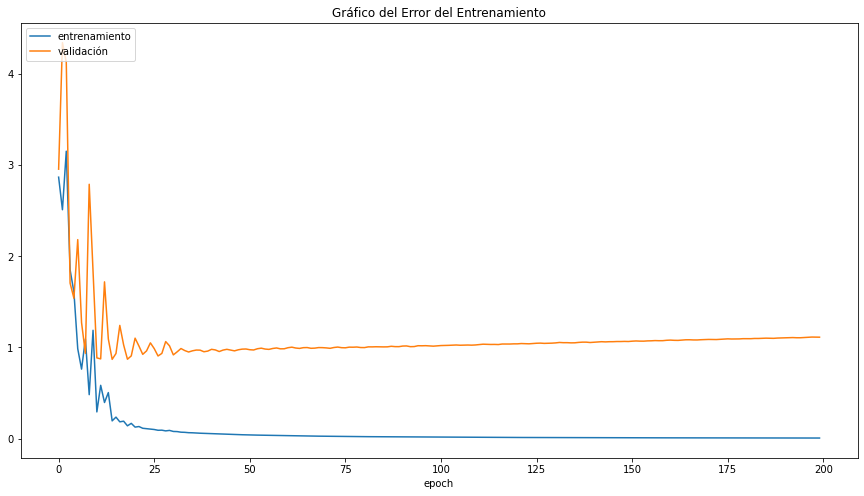

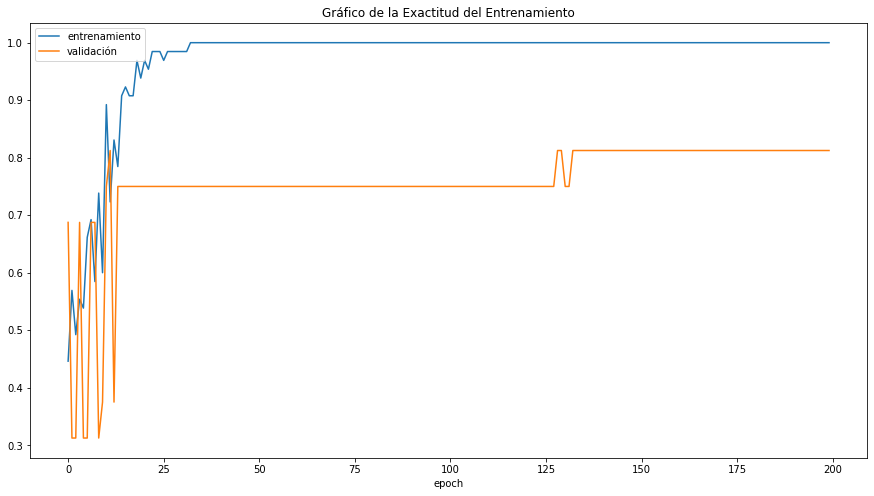

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [ ]:
!rm -rf /content/val
fid = drive.ListFile({'q':"title='fotos_val.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fotos_val.zip')
f.keys()
!unzip fotos_val.zip -d /content/val

Archive:  fotos_val.zip
   creating: /content/val/Buena/
  inflating: /content/val/Buena/20210603_172642.jpg  
  inflating: /content/val/Buena/20210603_173029.jpg  
  inflating: /content/val/Buena/20210603_173613.jpg  
  inflating: /content/val/Buena/20210603_174133.jpg  
  inflating: /content/val/Buena/20210603_174554.jpg  
   creating: /content/val/Mala/
  inflating: /content/val/Mala/20210603_173216.jpg  
  inflating: /content/val/Mala/20210603_173424.jpg  
  inflating: /content/val/Mala/20210603_174359.jpg  


In [ ]:
#@title Evaluacion contra test dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/val",
   seed=123,
   image_size=(img_width, img_height),
   batch_size=batch_size
)

test_ds = preprocess(test_ds)

test_images_normal = []
test_images = []
test_images_classes = []



# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)


for image, label in test_ds:
  # for displaying purposes
  test_images_normal.append(image)
  test_images_classes.append(label.numpy())

predictions = model.predict(test_ds)

test_predict = np.argmax(predictions,axis=1)
flattened_real =[item for sublist in test_images_classes for item in sublist]
test_real = np.array(flattened_real)

test_acc = sum(test_predict.tolist() == test_real) / len(test_real)                                       
print(f'Test set accuracy: {test_acc:.0%}')

Found 8 files belonging to 2 classes.
Test set accuracy: 75%


Now we display the info

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8

Heatmap de confusion o matriz


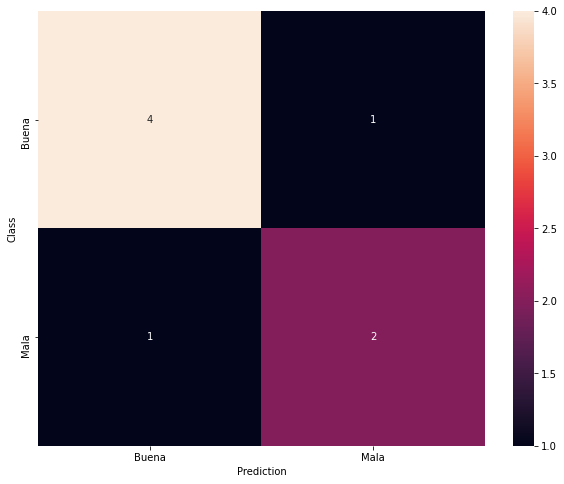

Example predictions


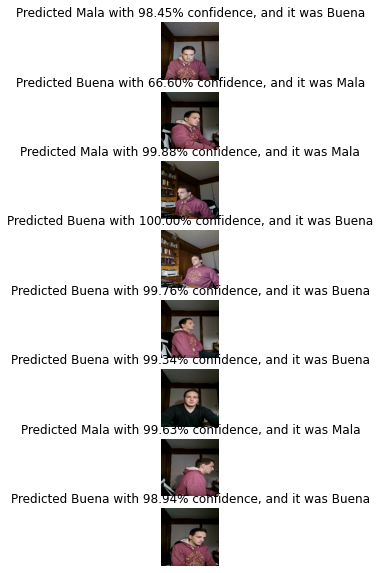

In [ ]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(test_real, test_predict)

# true_report = list(map(lambda x: class_names[x],flattened_real))
# prediction_report = list(map(lambda x: class_names[np.argmax(x)],test_predict.tolist()))
# print(classification_report(true_report,prediction_report)) 
print("Reporte de clasificacion")
print(classification_report(flattened_real,test_predict))

print("Heatmap de confusion o matriz")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Class')
plt.show()

print("Example predictions")
plt.figure(figsize=(10, 10))
position = 0
for batch in test_images_normal:
  for image in batch:
    prediction = tf.nn.softmax(predictions[position])
    label = flattened_real[position]
    position = position + 1
    ax = plt.subplot(len(batch),1, position)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Predicted {} with {:.2f}% confidence, and it was {}"
               .format(class_names[np.argmax(prediction)],100 * np.max(prediction),class_names[label]))
    plt.axis("off")
    


# Exportar csv para entrega

In [ ]:
from PIL import Image
import numpy as np
import sys
import os
import csv

#Useful function
def createFileList(myDir, format='.jpg'):
  fileList = []
  print(myDir)
  for root, dirs, files in os.walk(myDir, topdown=False):
      for name in files:
          if name.endswith(format):
              fullName = os.path.join(root, name)
              fileList.append(fullName)
  return fileList

# load the original image
myFileList = createFileList('/content/fotos/Mala/')

for file in myFileList:
    print(file)
    img_file = Image.open(file)
    # img_file.show()

    # get original image parameters...
    width, height = img_file.size
    format = img_file.format
    mode = img_file.mode

    # Make image Greyscale
    img_grey = img_file.convert('L')
    #img_grey.save('result.png')
    #img_grey.show()

    # Save Greyscale values
    value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
    value = value.flatten()
    print(value)
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

/content/fotos/Mala/
